<a href="https://colab.research.google.com/github/mfrdixon/alpha-RNN/blob/master/Alpha_RNNs_regime_switching_vols(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import pandas as pd
from numpy import random
import os# Generate switching data set
import random


# Imports for alpha_rnns 
from IPython import display
import tensorflow.compat.v1 as tf   
tf.disable_v2_behavior()
# Imports for stats
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU, SimpleRNN
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras.regularizers import l1,l2
from keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit


# To make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

Instructions for updating:
non-resource variables are not supported in the long term


Using TensorFlow backend.


In [0]:
def generate_vol_sample(length, sigma_0, n_steps, step_size, eps=0.01):
    sigma = np.array([0]*length, dtype='float64')
    sigma[0]=sigma_0
    mu = np.array([0]*length, dtype='float64')
    step_length=np.int(np.floor(np.float(length)/(2.0*n_steps)))
    
    for i in range(2*n_steps):
      mu[i*step_length:((i*step_length)+1)]=step_size*(-1)**i
     
    for i in range(1, length):
        sigma[i]=sigma[i-1] + mu[i] + eps*np.random.normal(0,1)
        
    return sigma   


In [0]:
def generate_vol_sample(length, sigma_0, n_steps, step_size, p, eps=0.01, shift=0):
    sigma = np.array([0]*length, dtype='float64')
    sigma[0]=sigma_0
    mu = np.array([0]*length, dtype='float64')
    phi = np.array([0]*length*p, dtype='float64').reshape(length,p)
    #phi2 = np.array([0]*length, dtype='float64')
    step_length=100 #np.int(np.floor(np.float(length)/(2.0*n_steps)))
    
    for i in range(2*n_steps):
      #mu[i*step_length:((i*step_length)+1)]=step_size #*(-1)**i
      mu[i*step_length:((i+1)*step_length)]= step_size*(-1)**i
      if i%2==0:  
        phi[i*step_length:((i+1)*step_length),:]= 0.02
        #phi2[i*step_length:((i+1)*step_length)]=1.0
      else:
        phi[i*step_length:((i+1)*step_length),:]=0.01
        #phi2[i*step_length:((i+1)*step_length)]=0.5
    for i in range(p, length):
        sigma[i]= mu[i-1] + np.random.normal(0,eps)
        for j in range(p):
          sigma[i]+=phi[i-1,j]*sigma[i-j]  
        
    return (sigma+shift)

In [0]:
p = 30 # the number of lags (in both the data and the models)
vols=generate_vol_sample(2000, 0.25, 15, 0.1, p, 1e-4, 0.13)[p:]

In [0]:
df = pd.DataFrame(vols, columns=['vol'])

In [6]:
use_features = ['vol'] 
target = 'vol'
n_steps = 10 # number of lags to include in the model

train_weight = 0.8
split = int(len(df)*train_weight)

df_train = df[use_features].iloc[:split]
print(df_train)
df_test = df[use_features].iloc[split:]

           vol
0     0.232024
1     0.233982
2     0.236243
3     0.238309
4     0.240423
...        ...
1571  0.149751
1572  0.153012
1573  0.156434
1574  0.159678
1575  0.163013

[1576 rows x 1 columns]


In [0]:
def get_lagged_features(value, n_steps):
    lag_list = []
    for lag in range(n_steps, 0, -1):
        lag_list.append(value.shift(lag))
    return pd.concat(lag_list, axis=1)

In [0]:
x_train_list = []
for use_feature in use_features:
    x_train_reg = get_lagged_features(df_train, n_steps).dropna()
    x_train_list.append(x_train_reg)
x_train_reg = pd.concat(x_train_list, axis=1)

col_ords = []
for i in range(n_steps):
    for j in range(len(use_features)):
        col_ords.append(i + j * n_steps)

x_train_reg = x_train_reg.iloc[:, col_ords]
y_train_reg = df_train.loc[x_train_reg.index, [target]].values
x_train_reg = np.reshape(x_train_reg.values, (x_train_reg.shape[0], np.int(x_train_reg.shape[1] / len(use_features)), len(use_features)))
y_train_reg = np.reshape(y_train_reg, (y_train_reg.shape[0], 1, 1))

x_test_list = []
for use_feature in use_features:
    x_test_reg = get_lagged_features(df_test, n_steps).dropna()
    x_test_list.append(x_test_reg)
x_test_reg = pd.concat(x_test_list, axis=1)

x_test_reg = x_test_reg.iloc[:, col_ords]
y_test_reg = df_test.loc[x_test_reg.index, [target]].values
x_test_reg = np.reshape(x_test_reg.values, (x_test_reg.shape[0], np.int(x_test_reg.shape[1]/len(use_features)), len(use_features)))

y_test_reg = np.reshape(y_test_reg, (y_test_reg.shape[0], 1, 1))

In [0]:
print(x_train_reg.shape,y_train_reg.shape,x_test_reg.shape,y_test_reg.shape)

(1566, 10, 1) (1566, 1, 1) (384, 10, 1) (384, 1, 1)


In [0]:
train_batch_size = y_train_reg.shape[0]
test_batch_size = y_test_reg.shape[0]

time_size = y_train_reg.shape[1]

In [0]:
print(train_batch_size)

1566


In [0]:
class alphaRNN:
    """Adapted from the Implementation of a Gated Recurrent Unit (GRU) as described in [1]. This is a GRU without a reset gate. It uses a hidden layer for smoothing
    
    [1] Chung, J., Gulcehre, C., Cho, K., & Bengio, Y. (2014). Empirical evaluation of gated recurrent neural networks on sequence modeling. arXiv preprint arXiv:1412.3555.
    
    Arguments
    ---------
    input_dimensions: int
        The size of the input vectors (x_t).
    hidden_size: int
        The size of the hidden layer vectors (h_t).
    dtype: obj
        The datatype used for the variables and constants (optional).
    """
    
    def __init__(self, input_dimensions, hidden_size, dtype=tf.float64):
        self.input_dimensions = input_dimensions
        self.hidden_size = hidden_size
        
        # Weights for input vectors of shape (input_dimensions, hidden_size)
        self.Walpha = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.input_dimensions, self.hidden_size), mean=0, stddev=0.01), name='Walpha')
        self.Wh = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.input_dimensions, self.hidden_size), mean=0, stddev=0.01), name='Wh')
        
        # Weights for hidden vectors of shape (hidden_size, hidden_size)
        self.Ualpha = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidden_size, self.hidden_size), mean=0, stddev=0.01), name='Ualpha')
        self.Uh = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidden_size, self.hidden_size), mean=0, stddev=0.01), name='Uh')
        
        # Biases for hidden vectors of shape (hidden_size,)
        self.balpha = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidden_size,), mean=0, stddev=0.01), name='balpha')
        self.bh = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidden_size,), mean=0, stddev=0.01), name='bh')
        
        # Define the input layer placeholder
        self.input_layer = tf.placeholder(dtype=tf.float64, shape=(None, None, input_dimensions), name='input')
        self.alpha_t = tf.placeholder(dtype=tf.float64, shape=(None, None, input_dimensions), name='alpha_t')
        # Put the time-dimension upfront for the scan operator
        self.x_t = tf.transpose(self.input_layer, [1, 0, 2], name='x_t')
        
        # A little hack (to obtain the same shape as the input matrix) to define the initial hidden state h_0
        self.h_0 = tf.matmul(self.x_t[0, :, :], tf.zeros(dtype=tf.float64, shape=(input_dimensions, hidden_size)), name='h_0')
        
        # Perform the scan operator
        self.h_t_transposed = tf.scan(self.forward_pass, self.x_t, initializer=self.h_0, name='h_t_transposed')
        
        # Transpose the result back
        self.h_t = tf.transpose(self.h_t_transposed, [1, 0, 2], name='h_t')

    def forward_pass(self, h_tm1, x_t):
        """Perform a forward pass.
        
        Arguments
        ---------
        h_tm1: np.matrix
            The hidden state at the previous timestep (h_{t-1}).
        x_t: np.matrix
            The input vector.
        """
        # Update alpha_t
        self.alpha_t = tf.sigmoid(tf.matmul(x_t, self.Walpha) + tf.matmul(h_tm1, self.Ualpha) + self.balpha)
        tf.add_to_collection('alpha_t', self.alpha_t)
        # Update hidden state h_t
        h_proposal = tf.tanh(tf.matmul(x_t, self.Wh) + tf.matmul(h_tm1, self.Uh) + self.bh)
        
        
        # Update the (smoothed) hidden state with exponential smoothing
        #h_t = tf.multiply(1 - self.alpha_t, h_tm1) + tf.multiply(self.alpha_t, h_proposal)
        h_t = tf.multiply(1 - tf.tanh(self.alpha_t), h_tm1) + tf.multiply(tf.tanh(self.alpha_t), h_proposal) 
        return h_t

In [0]:
tf.get_collection('alpha_t')

[<tf.Tensor 'h_t_transposed/while/Sigmoid:0' shape=(?, 10) dtype=float64>,
 <tf.Tensor 'h_t_transposed_2/while/Sigmoid:0' shape=(?, 10) dtype=float64>,
 <tf.Tensor 'h_t_transposed_3/while/Sigmoid:0' shape=(?, 10) dtype=float64>,
 <tf.Tensor 'h_t_transposed_4/while/Sigmoid:0' shape=(?, 10) dtype=float64>,
 <tf.Tensor 'h_t_transposed_5/while/Sigmoid:0' shape=(?, 10) dtype=float64>,
 <tf.Tensor 'h_t_transposed_6/while/Sigmoid:0' shape=(?, 10) dtype=float64>,
 <tf.Tensor 'h_t_transposed_7/while/Sigmoid:0' shape=(?, 10) dtype=float64>,
 <tf.Tensor 'h_t_transposed_8/while/Sigmoid:0' shape=(?, 10) dtype=float64>,
 <tf.Tensor 'h_t_transposed_9/while/Sigmoid:0' shape=(?, 10) dtype=float64>,
 <tf.Tensor 'h_t_transposed_10/while/Sigmoid:0' shape=(?, 10) dtype=float64>,
 <tf.Tensor 'h_t_transposed_11/while/Sigmoid:0' shape=(?, 10) dtype=float64>,
 <tf.Tensor 'h_t_transposed_12/while/Sigmoid:0' shape=(?, 10) dtype=float64>,
 <tf.Tensor 'h_t_transposed_13/while/Sigmoid:0' shape=(?, 10) dtype=float64

In [0]:
class simpleAlphaRNN:
    """Adapted from the Implementation of a Gated Recurrent Unit (GRU) as described in [1]. This is a GRU without a reset gate. 
       It uses a scalar smoothing
    
    
    Arguments
    ---------
    
    input_dimensions: int
        The size of the input vectors (x_t).
    hidden_size: int
        The size of the hidden layer vectors (h_t).
    dtype: obj
        The datatype used for the variables and constants (optional).
        
    Todo
    --------
    1) how to constrain alpha to be in [0,1]?
    2) when hidden size >1, how to couple with scalar alpha?
    3) Should alpha be a vector of size hidden_size (is this better)?
    4) Get value of fitted alpha (see Diagnostics (visualize fitted values)) below
    4) Adapt the training to use early stopping (instead of fixed number of epoches)
    5) Compare with GRU, LSTM, simpleRNN
        
    """
    
    def __init__(self, input_dimensions, hidden_size, dtype=tf.float64):
        self.input_dimensions = input_dimensions
        self.hidden_size = hidden_size
        
        self.Wh = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.input_dimensions, self.hidden_size), mean=0, stddev=0.01), name='Wh')
        
        # Weights for hidden vectors of shape (hidden_size, hidden_size)
        self.Uh = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidden_size, self.hidden_size), mean=0, stddev=0.01), name='Uh')
        
        # Biases for hidden vectors of shape (hidden_size,)
        self.bh = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidden_size,), mean=0, stddev=0.01), name='bh')
        
        # Define the input layer placeholder
        self.input_layer = tf.placeholder(dtype=tf.float64, shape=(None, None, input_dimensions), name='input')
        self.alpha = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidden_size,), mean=0, stddev=0.01), name='alpha')
        
        #tf.placeholder(dtype=tf.float64, shape=(None, 1), name='alpha')
        # Put the time-dimension upfront for the scan operator
        self.x_t = tf.transpose(self.input_layer, [1, 0, 2], name='x_t')
        
        # A little hack (to obtain the same shape as the input matrix) to define the initial hidden state h_0
        self.h_0 = tf.matmul(self.x_t[0, :, :], tf.zeros(dtype=tf.float64, shape=(input_dimensions, hidden_size)), name='h_0')
        
        # Perform the scan operator
        self.h_t_transposed = tf.scan(self.forward_pass, self.x_t, initializer=self.h_0, name='h_t_transposed')
        
        # Transpose the result back
        self.h_t = tf.transpose(self.h_t_transposed, [1, 0, 2], name='h_t')

    def forward_pass(self, h_tm1, x_t):
        """Perform a forward pass.
        
        Arguments
        ---------
        h_tm1: np.matrix
            The hidden state at the previous timestep (h_{t-1}).
        x_t: np.matrix
            The input vector.
        """
        
        # Update hidden state h_t
        h_proposal = tf.tanh(tf.matmul(x_t, self.Wh) + tf.matmul(h_tm1, self.Uh) + self.bh)
        
        # Update the (smoothed) hidden state with exponential smoothing
        h_t = tf.multiply(1 - tf.tanh(self.alpha), h_tm1) + tf.multiply(tf.tanh(self.alpha), h_proposal)
        
        return h_t

In [0]:
    
#%% (3) Initialize and train the model.

# The input has 2 dimensions: dimension 0 is reserved for the first term and dimension 1 is reserved for the second term
input_dimensions = 1

# Arbitrary number for the size of the hidden state
hidden_size = 10 #<= MFD: vary this between 1,2,5,10,20

In [0]:
def train(alpharnn, train_x, val_x, train_y, val_y, max_epochs=2000, batch_size=100):
    
  # Create a placeholder for the expected output
  expected_output_batch_train = tf.placeholder(dtype=tf.float64, shape=(batch_size, time_size,1), name='expected_output_batch_train')
  expected_output_train = tf.placeholder(dtype=tf.float64, shape=(train_x.shape[0], time_size,1), name='expected_output_train')
  #expected_output_test = tf.placeholder(dtype=tf.float64, shape(test_x.shape[0], time_size,1), name='expected_output_test')
  expected_output_val = tf.placeholder(dtype=tf.float64, shape=(val_x.shape[0], time_size,1), name='expected_output_val')

  #expected_output = tf.placeholder(dtype=tf.float64, shape=(batch_size, time_size), name='expected_output')

  # Just use quadratic loss
  train_batch_loss = tf.reduce_sum(0.5 * tf.pow(output - expected_output_batch_train, 2)) / float(batch_size)
  train_loss = tf.reduce_sum(0.5 * tf.pow(output - expected_output_train, 2)) / float(train_x.shape[0])
  validation_loss = tf.reduce_sum(0.5 * tf.pow(output - expected_output_val, 2)) / float(val_x.shape[0])

  #accuracy = tf.reduce_mean(tf.cast(validation_loss, tf.float64))

  # Use the Adam optimizer for training
  train_step = tf.train.AdamOptimizer().minimize(train_batch_loss)
    
  # Initialize the losses
  train_losses = []
  validation_losses = []
      
  # Initialize all the variables
  init_variables = tf.global_variables_initializer()
      
  #myNumpyData = np.ones([10,20])
  session.run(init_variables) # , {gru.Y: np.ones([20,20])})
 
  # Perform all the iterations
  patience_cnt = 0
  for epoch in range(max_epochs): # Compute the losses
        patience = 50
        min_delta = 0.000001
        

        total_batch = int(train_x.shape[0] / batch_size)
    
        for i in range(total_batch):
          batch_x = train_x[i*batch_size:(i+1)*batch_size]
          batch_y = train_y[i*batch_size:(i+1)*batch_size]
          session.run([train_step], feed_dict={alpharnn.input_layer: batch_x, expected_output_batch_train: batch_y})        
        train_loss_ = session.run(train_loss, feed_dict={alpharnn.input_layer: train_x, expected_output_train: train_y})
        validation_loss_ = session.run(validation_loss, feed_dict={alpharnn.input_layer: val_x, expected_output_val: val_y})

        # Log the losses
        train_losses += [train_loss_]
        validation_losses += [validation_loss_]
          #mse = mean_squared_error(train_losses,validation_losses) <= this is wrong! 
          # I know...it's original values and the predicted values
        #keras uses: model.compile(loss='mean_squared_error', optimizer='sgd') 
        # and: keras.losses.mean_squared_error(y_true, y_pred)
        #y_predicted = session.run(output, feed_dict={alpharnn.input_layer: x_test_reg})
        #MSE = np.square(np.subtract(y_test_reg,y_predicted)).mean()

        if epoch % 50 == 0: 
            print('Epoch ', epoch, '/', max_epochs, ': ',
                      "\tTraining Loss: {:.5f}".format(train_loss_),
                      "\tValidation Loss: {:.5f}".format(validation_loss_),
                      #"\tloss:", MSE                      

                 )
        if epoch > 0 and (validation_losses[epoch-1] - validation_losses[epoch]) > min_delta:
            patience_cnt = 0
        else:
            patience_cnt += 1
            #print(patience_cnt)
        if patience_cnt > patience:
            print("Early stopping")
            break
  saver = tf.train.Saver()
  saved_path = saver.save(session, './saved_variable')          
  #print('\nMSE: ',mse)
  plt.plot(train_losses, '-b', label='Train loss')
  plt.plot(validation_losses, '-r', label='Validation loss')
  plt.legend(loc=0)
  plt.title('Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.show()
  return alpharnn, validation_losses[-1]        

In [0]:
## MFD: ignore - not correct
def cross_validate(session, split_size):

  results = []

  tscv = TimeSeriesSplit(split_size)
    
  """
  The training set has size i * n_samples // (n_splits + 1) + n_samples % (n_splits + 1) 
  in the i``th split, with a test set of size ``n_samples//(n_splits + 1), 
  where n_samples is the number of samples.
  
  """

  for train_idx, val_idx in tscv.split(x_train_reg):
    print("TRAIN:", train_idx.shape, "TEST:", val_idx.shape)
    expected_output_val = tf.placeholder(dtype=tf.float64, shape=(len(val_idx), time_size,1), name='expected_output_val')

    train_x = x_train_reg[train_idx]
    train_y = y_train_reg[train_idx]

    val_x = x_train_reg[val_idx]
    val_y = y_train_reg[val_idx]
    
    train(alpharnn, train_x, val_x, train_y, val_y)
    val_loss = tf.reduce_sum(0.5 * tf.pow(output - expected_output_val, 2)) / float(len(val_idx))
  
    # MFD: suggest to change to val_loss and not use train_loss
    results.append(session.run(val_loss, feed_dict={alpharnn.input_layer: val_x, expected_output_val: val_y}))

  return results

In [0]:
## MFD: ignore - not correct
def cross_validate_t(session, split_size):

  models = []

  tscv = TimeSeriesSplit(split_size)
    
  """
  The training set has size i * n_samples // (n_splits + 1) + n_samples % (n_splits + 1) 
  in the i``th split, with a test set of size ``n_samples//(n_splits + 1), 
  where n_samples is the number of samples.
  
  """

  for train_idx, val_idx in tscv.split(x_train_reg):
    print("TRAIN:", train_idx.shape, "TEST:", val_idx.shape)
    #expected_output_val = tf.placeholder(dtype=tf.float64, shape=(len(val_idx), time_size,1), name='expected_output_val')

    train_x = x_train_reg[train_idx]
    train_y = y_train_reg[train_idx]

    val_x = x_train_reg[val_idx]
    val_y = y_train_reg[val_idx]
    
    model=train(alpharnn_t, train_x, val_x, train_y, val_y)
    #val_loss = tf.reduce_sum(0.5 * tf.pow(output - expected_output_val, 2)) / float(len(val_idx))
  
    # MFD: suggest to change to val_loss and not use train_loss
    #results.append(session.run(val_loss, feed_dict={alpharnn_t.input_layer: val_x, expected_output_val: val_y}))
    models.append(model)
  return models

In [22]:


#MSE_train = 0
#MSE_test = 0 
#models = []
#n_splits = 10
#tscv = TimeSeriesSplit(n_splits = 10)
#for train_fold, test_fold in tscv.split(x_train_reg):
  #x_train, x_test = x_train_reg[train_fold], x_train_reg[test_fold]
  #y_train, y_test = y_train_reg[train_fold], y_test_reg[test_fold]
session = tf.Session()
  # Add an additional layer on top of each of the hidden state outputs
alpharnn = simpleAlphaRNN(input_dimensions, hidden_size)
W_output = tf.Variable(tf.truncated_normal(dtype=tf.float64, shape=(hidden_size, 1), mean=0, stddev=0.01))
b_output = tf.Variable(tf.truncated_normal(dtype=tf.float64, shape=(1,), mean=0, stddev=0.01))
output = tf.map_fn(lambda h_t: tf.matmul(h_t, W_output) + b_output, alpharnn.h_t) 
train(alpharnn, x_train_reg, x_test_reg, y_train_reg, y_test_reg) 

#for model in models:
#y_predicted = session.run(output, feed_dict={alpharnn.input_layer: x_test_reg})
#y_predicted_ar =np.array([0]*y_predicted_t.shape[0], dtype='float64')
#for i in range(y_predicted_t.shape[0]):
  #y_predicted_ar[i]=y_predicted[i][n_steps-1][0]
  #MSE_test += mean_squared_error(y_test[:,0],y_predicted_ar[i])

#y_predicted = session.run(output, feed_dict={alpharnn.input_layer: x_train_reg})
#y_predicted_ar_train =np.array([0]*y_predicted.shape[0], dtype='float64')
#for i in range(y_predicted.shape[0]):
  #y_predicted_ar_train[i]=y_predicted[i][n_steps-1][0]
  #MSE_train += mean_squared_error(y_train[:,0],y_predicted_ar_train[i])
  
  #MSE_train_alpha = MSE_train/n_splits
  #print("MSE train alpha = " + str(MSE_train_alpha))
  #MSE_test_alpha = MSE_test/n_splits
  #print("MSE test alpha = " + str(MSE_test_alpha))
  #MSE_train_alpha_std = np.math.sqrt(MSE_train_alpha/(n_splits-1))
  #MSE_test_alpha_std = np.math.sqrt(MSE_test_alpha/(n_splits-1))
  #print("MSE_train_alpha_std = " + str(MSE_train_alpha_std))
  #print("MSE_test_alpha_std = " + str(MSE_test_alpha_std))

Epoch  0 / 2000 :  	Training Loss: 0.19371 	Validation Loss: 0.20065


KeyboardInterrupt: ignored

In [0]:
#y_predicted = session.run(output, feed_dict={alpharnn.input_layer: x_train_reg})
#y_predicted_ar_train=np.array([0]*y_predicted.shape[0], dtype='float64')
#for i in range(y_predicted.shape[0]):
#     y_predicted_ar_train[i]=y_predicted[i][n_steps-1][0]

In [0]:
#y_predicted = session.run(output, feed_dict={alpharnn.input_layer: x_test_reg})
#y_predicted_ar=np.array([0]*y_predicted.shape[0], dtype='float64')
#for i in range(y_predicted.shape[0]):
#     y_predicted_ar[i]=y_predicted[i][n_steps-1][0]

This is the main workflow=>



Epoch  0 / 2000 :  	Training Loss: 0.25716 	Validation Loss: 0.15458
Epoch  50 / 2000 :  	Training Loss: 0.08123 	Validation Loss: 0.09600
Epoch  100 / 2000 :  	Training Loss: 0.02796 	Validation Loss: 0.03344
Epoch  150 / 2000 :  	Training Loss: 0.01862 	Validation Loss: 0.02340
Epoch  200 / 2000 :  	Training Loss: 0.01615 	Validation Loss: 0.02204
Epoch  250 / 2000 :  	Training Loss: 0.01465 	Validation Loss: 0.02120
Epoch  300 / 2000 :  	Training Loss: 0.01367 	Validation Loss: 0.02065
Epoch  350 / 2000 :  	Training Loss: 0.01300 	Validation Loss: 0.02026
Epoch  400 / 2000 :  	Training Loss: 0.01254 	Validation Loss: 0.01998
Epoch  450 / 2000 :  	Training Loss: 0.01221 	Validation Loss: 0.01979
Epoch  500 / 2000 :  	Training Loss: 0.01197 	Validation Loss: 0.01965
Epoch  550 / 2000 :  	Training Loss: 0.01180 	Validation Loss: 0.01956
Epoch  600 / 2000 :  	Training Loss: 0.01167 	Validation Loss: 0.01950
Epoch  650 / 2000 :  	Training Loss: 0.01159 	Validation Loss: 0.01946
Early sto

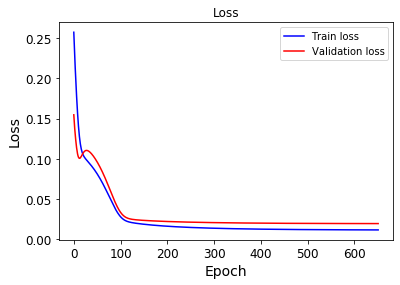

Epoch  0 / 2000 :  	Training Loss: 0.20970 	Validation Loss: 0.16906
Epoch  50 / 2000 :  	Training Loss: 0.02508 	Validation Loss: 0.02236
Epoch  100 / 2000 :  	Training Loss: 0.01876 	Validation Loss: 0.01731
Epoch  150 / 2000 :  	Training Loss: 0.01671 	Validation Loss: 0.01561
Epoch  200 / 2000 :  	Training Loss: 0.01584 	Validation Loss: 0.01489
Epoch  250 / 2000 :  	Training Loss: 0.01547 	Validation Loss: 0.01458
Epoch  300 / 2000 :  	Training Loss: 0.01531 	Validation Loss: 0.01445
Epoch  350 / 2000 :  	Training Loss: 0.01525 	Validation Loss: 0.01440
Early stopping


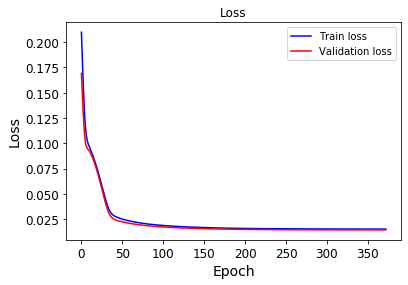

Epoch  0 / 2000 :  	Training Loss: 0.19956 	Validation Loss: 0.26478
Epoch  50 / 2000 :  	Training Loss: 0.01851 	Validation Loss: 0.01719
Epoch  100 / 2000 :  	Training Loss: 0.01540 	Validation Loss: 0.01281
Epoch  150 / 2000 :  	Training Loss: 0.01501 	Validation Loss: 0.01217
Epoch  200 / 2000 :  	Training Loss: 0.01498 	Validation Loss: 0.01209
Early stopping


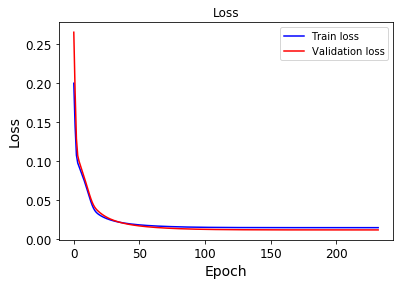

Epoch  0 / 2000 :  	Training Loss: 0.15814 	Validation Loss: 0.14621
Epoch  50 / 2000 :  	Training Loss: 0.01512 	Validation Loss: 0.01980
Epoch  100 / 2000 :  	Training Loss: 0.01427 	Validation Loss: 0.01903
Epoch  150 / 2000 :  	Training Loss: 0.01422 	Validation Loss: 0.01895
Early stopping


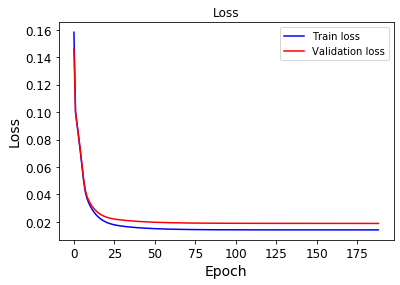

Epoch  0 / 2000 :  	Training Loss: 0.10724 	Validation Loss: 0.10300
Epoch  50 / 2000 :  	Training Loss: 0.01527 	Validation Loss: 0.01350
Epoch  100 / 2000 :  	Training Loss: 0.01515 	Validation Loss: 0.01336
Early stopping


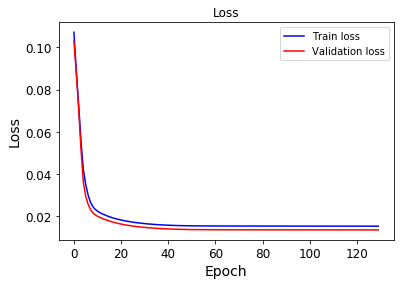

In [29]:
models = []
MSE_train = 0 
MSE_test = 0
n_splits = 5
tscv = TimeSeriesSplit(n_splits)
hidden_sizes=[1,2,5,10,20]
i=0
val_losses=[]
for train_fold, test_fold in tscv.split(x_train_reg):
  x_train, x_test = x_train_reg[train_fold], x_train_reg[test_fold]
  y_train, y_test = y_train_reg[train_fold], y_train_reg[test_fold]
  session = tf.Session()
  # Add an additional layer on top of each of the hidden state outputs
  alpharnn_t = alphaRNN(input_dimensions, hidden_sizes[i])
  W_output = tf.Variable(tf.truncated_normal(dtype=tf.float64, shape=(hidden_sizes[i], 1), mean=0, stddev=0.01))
  b_output = tf.Variable(tf.truncated_normal(dtype=tf.float64, shape=(1,), mean=0, stddev=0.01))
  output = tf.map_fn(lambda h_t: tf.matmul(h_t, W_output) + b_output, alpharnn_t.h_t) 
  #models.append(train(alpharnn_t, x_train, x_test, y_train, y_test)) 
  model, val_loss=train(alpharnn_t, x_train, x_test, y_train, y_test, max_epochs=2000, batch_size=int(100/n_splits))
  val_losses.append(val_loss)
  models.append(model)
  i+=1

Pick the model with the lowest val loss. you can *not* use the test set for model selection! This would be cheating


> Indented block



In [32]:
#Pick the model with the lowest val_loss. Retrain it on all data and then perform prediction
val, idx = min((val, idx) for (idx, val) in enumerate(val_losses))
print(hidden_sizes[idx])

5


Epoch  0 / 2000 :  	Training Loss: 0.21901 	Validation Loss: 0.22637
Epoch  50 / 2000 :  	Training Loss: 0.02302 	Validation Loss: 0.02236
Epoch  100 / 2000 :  	Training Loss: 0.01544 	Validation Loss: 0.01420
Epoch  150 / 2000 :  	Training Loss: 0.01484 	Validation Loss: 0.01350
Epoch  200 / 2000 :  	Training Loss: 0.01480 	Validation Loss: 0.01346
Early stopping


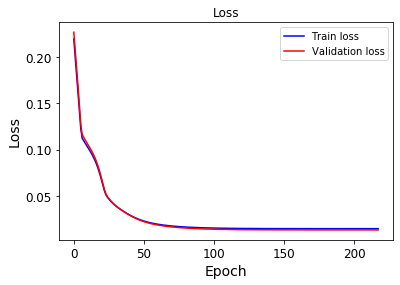

In [35]:
session = tf.Session()
  # Add an additional layer on top of each of the hidden state outputs
alpharnn = simpleAlphaRNN(input_dimensions, hidden_sizes[idx])
W_output = tf.Variable(tf.truncated_normal(dtype=tf.float64, shape=(hidden_sizes[idx], 1), mean=0, stddev=0.01))
b_output = tf.Variable(tf.truncated_normal(dtype=tf.float64, shape=(1,), mean=0, stddev=0.01))
output = tf.map_fn(lambda h_t: tf.matmul(h_t, W_output) + b_output, alpharnn.h_t) 
model,_=train(alpharnn, x_train_reg, x_test_reg, y_train_reg, y_test_reg) 

In [0]:
y_predicted_t = session.run(output, feed_dict={model.input_layer: x_test_reg})
y_predicted_ar_t=np.array([0]*y_predicted_t.shape[0], dtype='float64')
for i in range(y_predicted_t.shape[0]):
     y_predicted_ar_t[i]=y_predicted_t[i][n_steps-1][0]

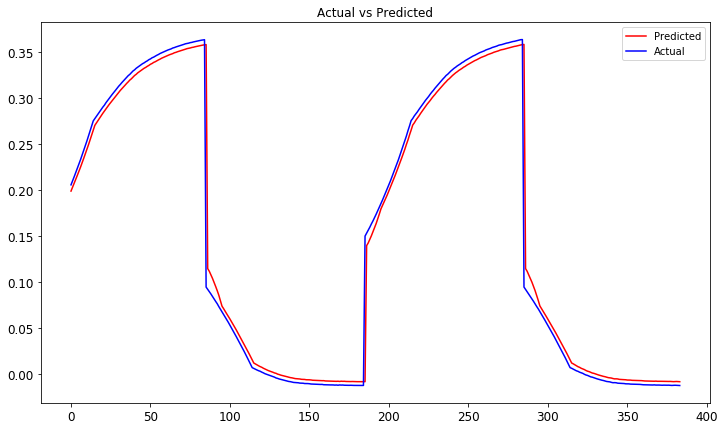

In [37]:
fig = plt.figure(figsize=(12,7))
plt.plot(y_predicted_ar_t, color='r', label='Predicted')
plt.plot(y_test_reg.flatten(),'b', label='Actual')
plt.legend(loc=0)
plt.title('Actual vs Predicted')
plt.show()

In [0]:
###Ignore everything below this cell


# you don't need this...
for model in models:
  #print("model = " + str(model))
  y_predicted_t = session.run(output, feed_dict={model.input_layer: x_test_reg})
  y_predicted_ar_t=np.array([0]*y_predicted_t.shape[0], dtype='float64')
  for i in range(y_predicted_t.shape[0]):
  y_predicted_ar_t[i]=y_predicted_t[i][n_steps-1][0]
      #print("y_predicted_ar_t " + str(y_predicted_ar_t[i]))
      MSE_test += mean_squared_error(y_test[:,0],y_predicted_ar_t[i])
      print("MSE test " + str(MSE_test))

  y_predicted_t = session.run(output, feed_dict={model.input_layer: x_train_reg})
  y_predicted_ar_train_t=np.array([0]*y_predicted_t.shape[0], dtype='float64')
  for i in range(y_predicted_t.shape[0]):
     y_predicted_ar_train_t[i]=y_predicted_t[i][n_steps-1][0]
     MSE_train += mean_squared_error(y_train[:,0],y_predicted_ar_train_t[i])
  
MSE_train_alpha_t = MSE_train/n_splits
print("MSE train alpha_t = " + str(MSE_train_alpha_t))
MSE_test_alpha_t = MSE_test/n_splits
print("MSE test alpha_t = " + str(MSE_test_alpha_t))
MSE_train_alpha_t_std = np.math.sqrt(MSE_train_alpha_t/(n_splits-1))
MSE_test_alpha_t_std = np.math.sqrt(MSE_test_alpha_t/(n_splits-1))
print("MSE_train_alpha_t std = " + str(MSE_train_alpha_t_std))
print("MSE_test_alpha_t std = " + str(MSE_test_alpha_t_std))

In [0]:
y_predicted_t = session.run(output, feed_dict={alpharnn_t.input_layer: x_test_reg})
y_predicted_ar_t=np.array([0]*y_predicted_t.shape[0], dtype='float64')
for i in range(y_predicted_t.shape[0]):
     y_predicted_ar_t[i]=y_predicted_t[i][n_steps-1][0]

In [0]:
y_predicted_t = session.run(output, feed_dict={alpharnn_t.input_layer: x_train_reg})
y_predicted_ar_train_t=np.array([0]*y_predicted_t.shape[0], dtype='float64')
for i in range(y_predicted_t.shape[0]):
     y_predicted_ar_train_t[i]=y_predicted_t[i][n_steps-1][0]

In [0]:
#train_loss = 0
#expected_output_test = 0
with tf.Session() as session:
  #saved_path = saver.save(session, './saved_variable')
  #result = cross_validate(session, 5)
  #print('Cross-validation result: %s' % result)
  print('Test accuracy: %f' % session.run(train_loss, feed_dict={alpharnn_t.input_layer: x_test_reg, expected_output_test: y_test_reg}))

In [0]:
y_predicted = session.run(output, feed_dict={alpharnn.input_layer: x_test_reg})
y_predicted_ar=np.array([0]*y_predicted.shape[0], dtype='float64')
for i in range(y_predicted.shape[0]):
     y_predicted_ar[i]=y_predicted[i][n_steps-1][0]

In [0]:
y_predicted = session.run(output, feed_dict={alpharnn.input_layer: x_train_reg})
y_predicted_ar_train=np.array([0]*y_predicted.shape[0], dtype='float64')
for i in range(y_predicted.shape[0]):
     y_predicted_ar_train[i]=y_predicted[i][n_steps-1][0]

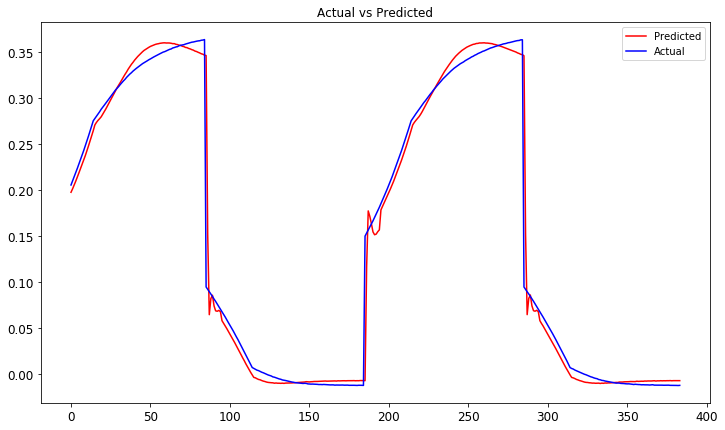

In [0]:
fig = plt.figure(figsize=(12,7))
plt.plot(y_predicted_ar, color='r', label='Predicted')
plt.plot(y_test_reg.flatten(),'b', label='Actual')
plt.legend(loc=0)
plt.title('Actual vs Predicted')
plt.show()

In [0]:

with tf.Session() as session:
  #saved_path = saver.save(session, './saved_variable')
  #result = cross_validate(session, 5)
  #print('Cross-validation result: %s' % result)
  print('Test accuracy: %f' % session.run(train_loss, feed_dict={alpharnn.input_layer: x_test_reg, expected_output_test: y_test_reg}))

In [0]:
print(train_losses[0][1])

NameError: ignored

In [0]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU, SimpleRNN
from keras import optimizers
from keras.callbacks import EarlyStopping

In [0]:
x_train_reg = pd.concat(x_train_list, axis=1)
x_train_reg = x_train_reg.iloc[:, col_ords]
y_train_reg = df_train.loc[x_train_reg.index, [target]].values
x_train_reg = np.reshape(x_train_reg.values, (x_train_reg.shape[0], np.int(x_train_reg.shape[1] / len(use_features)), len(use_features)))

In [0]:
x_test_reg = pd.concat(x_test_list, axis=1)
x_test_reg = x_test_reg.iloc[:, col_ords]
y_test_reg = df_test.loc[x_test_reg.index, [target]].values
x_test_reg = np.reshape(x_test_reg.values, (x_test_reg.shape[0], np.int(x_test_reg.shape[1]/len(use_features)), len(use_features)))

In [0]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, min_delta=0.0001)

In [0]:
def RNN_model2(n_units=10, l1_reg=0):
    reg_model = Sequential()
    reg_model.add(SimpleRNN(n_units, activation='relu', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
    reg_model.add(Dense(1, kernel_initializer='normal', kernel_regularizer=l1(l1_reg)))
    #reg_model.add(Dropout(0.2))
    reg_model.compile(loss='mean_squared_error', optimizer='adam')
    return reg_model

def GRU_model2(n_units = 10, l1_reg=0):
    reg_model = Sequential()
    reg_model.add(GRU(n_units, activation='relu', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
    reg_model.add(Dense(1, kernel_initializer='normal', kernel_regularizer=l1(l1_reg)))
    #reg_model.add(Dropout(0.2))
    reg_model.compile(loss='mean_squared_error', optimizer='adam')
    return reg_model

def LSTM_model2(n_units = 10, l1_reg=0):
    reg_model = Sequential()
    reg_model.add(LSTM(n_units, activation='relu', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
    #LPNorm.build_loss(p = float('inf'))
    reg_model.add(Dense(1, kernel_initializer='normal', kernel_regularizer=l1(l1_reg)))
    #reg_model.add(Dropout(0.2))
    reg_model.compile(loss='mean_squared_error', optimizer='adam')
    return reg_model

In [0]:
n_units = [10, 20, 30, 40, 50, 60, 100]
l1_reg = [0]  #[0, 0.001]   #0.01, 0.1]
#param_grid = dict(epochs=epochs,batch_size =batch_size)
                  #n_neurons=n_neurons)
                  #optimizers=optimizers,
                  #n_neurons = n_neurons)
#learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
#momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
#weight_constraint = [1, 2, 3, 4, 5]
#dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
tscv = TimeSeriesSplit(n_splits = 10)
param_grid = dict(n_units=n_units,l1_reg=l1_reg) 
#X_train, X_test, y_train, y_test = train_test_split(x_train_reg, y_train_reg, test_size=0.5, random_state=0) 
print("Hyper parameter tuning for RNN...")
model = KerasRegressor(build_fn=RNN_model2, epochs=2000, batch_size=100, verbose=1)
grid = GridSearchCV(estimator=model,param_grid=param_grid, cv=tscv, n_jobs=-1)
grid_result = grid.fit(x_train_reg,y_train_reg,callbacks=[es])
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with %r" % (mean, stdev, param))
# Manual CV
nodes = grid_result.best_params_['n_units']
l1_reg = grid_result.best_params_['l1_reg']
#n_units = [10, 20, 30, 40, 50, 60, 100]

Hyper parameter tuning for RNN...


/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Epoch 1/2000
1566/1566 [==============================] - 13s 8ms/step - loss: 0.0413
Epoch 2/2000
1566/1566 [==============================] - 0s 28us/step - loss: 0.0229
Epoch 3/2000
1566/1566 [==============================] - 0s 27us/step - loss: 0.0027
Epoch 4/2000
1566/1566 [==============================] - 0s 29us/step - loss: 0.0011
Epoch 5/2000
1566/1566 [==============================] - 0s 28us/step - loss: 9.1861e-04
Epoch 6/2000
 100/1566 [>.............................] - ETA: 0s - loss: 1.6546e-04

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:842: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


1566/1566 [==============================] - 0s 31us/step - loss: 8.6794e-04
Epoch 7/2000
1566/1566 [==============================] - 0s 29us/step - loss: 8.2146e-04
Epoch 8/2000
1566/1566 [==============================] - 0s 32us/step - loss: 7.8715e-04
Epoch 9/2000
1566/1566 [==============================] - 0s 33us/step - loss: 7.5906e-04
Epoch 10/2000
1566/1566 [==============================] - 0s 32us/step - loss: 7.1665e-04
Epoch 11/2000
1566/1566 [==============================] - 0s 31us/step - loss: 6.9844e-04
Epoch 12/2000
1566/1566 [==============================] - 0s 28us/step - loss: 6.6641e-04
Epoch 13/2000
1566/1566 [==============================] - 0s 28us/step - loss: 6.5739e-04
Epoch 14/2000
1566/1566 [==============================] - 0s 32us/step - loss: 6.4485e-04
Epoch 15/2000
1566/1566 [==============================] - 0s 30us/step - loss: 6.3995e-04
Epoch 16/2000
1566/1566 [==============================] - 0s 31us/step - loss: 6.0124e-04
Epoch 17/2000
15

In [0]:
param_grid = dict(n_units=n_units,l1_reg=l1_reg) 
n_splits = 10
#kf = KFold(n_splits)
#kf.get_n_splits(x_train_reg)
MSE_train = 0
MSE_test = 0
TimeSeriesSplit(max_train_size=None, n_splits=10)
tscv = TimeSeriesSplit()
for train_fold, test_fold in tscv.split(x_train_reg):
    x_train, x_test = x_train_reg[train_fold], x_train_reg[test_fold]
    y_train, y_test = y_train_reg[train_fold], y_train_reg[test_fold]
    rnn_model = RNN_model2(nodes,l1_reg)
   
    rnn_fit = rnn_model.fit(x_train,y_train, epochs=2000, batch_size=100, callbacks=[es])
    rnn_pred_train = rnn_model.predict(x_train, verbose=0)
    rnn_pred_test = rnn_model.predict(x_test, verbose=0) 

    # hyper parameter turning
    #MSE_train = mean_squared_error(df_train[use_feature][n_steps:], rnn_pred_train[:,0])
    MSE_train += mean_squared_error(y_train[:,0], rnn_pred_train[:,0])
    MSE_test += mean_squared_error(y_test[:,0], rnn_pred_test[:,0])
    #MSE_test = mean_squared_error(df_test[use_feature][n_steps:], rnn_pred_test[:,0])
    
rnn_model.summary()
MSE_train_ave = MSE_train/n_splits
MSE_train_std = np.math.sqrt(MSE_train/(n_splits-1))
MSE_test_ave = MSE_test/n_splits
MSE_test_std = np.math.sqrt(MSE_test/(n_splits-1))
print("MSE_train_rnn_ave = " + str(MSE_train_ave))
print("MSE_test_rnn_ave = " + str(MSE_test_ave))
print("MSE_train_rnn_std = " + str(MSE_train_std))
print("MSE_test_rnn_std = " + str(MSE_test_std))
print("p = " + str(p))

rnn_model = RNN_model2(nodes,l1_reg)
rnn_fit = rnn_model.fit(x_test_reg,y_test_reg, epochs=500, batch_size=100, callbacks=[es])
rnn_pred_test = rnn_model.predict(x_test_reg,verbose=1)
mse = mean_squared_error(y_test_reg[:,0],rnn_pred_test[:,0])
print("RNN test data mse = " + str(mse))
print("RNN test std mse = " + str(np.sqrt(mse)))
rnn_model.summary()




Epoch 1/2000
261/261 [==============================] - 1s 5ms/step - loss: 0.0433
Epoch 2/2000
261/261 [==============================] - 0s 58us/step - loss: 0.0287
Epoch 3/2000
261/261 [==============================] - 0s 51us/step - loss: 0.0152
Epoch 4/2000
261/261 [==============================] - 0s 65us/step - loss: 0.0048
Epoch 5/2000
261/261 [==============================] - 0s 63us/step - loss: 0.0043
Epoch 6/2000
261/261 [==============================] - 0s 65us/step - loss: 0.0042
Epoch 7/2000
261/261 [==============================] - 0s 68us/step - loss: 0.0012
Epoch 8/2000
261/261 [==============================] - 0s 61us/step - loss: 0.0027
Epoch 9/2000
261/261 [==============================] - 0s 59us/step - loss: 0.0019
Epoch 10/2000
261/261 [==============================] - 0s 66us/step - loss: 9.2133e-04
Epoch 11/2000
261/261 [==============================] - 0s 55us/step - loss: 0.0012
Epoch 12/2000
261/261 [==============================] - 0s 57us/step -

ValueError: ignored

In [0]:
print("Cross Validating LSTM with optmized parameters....")
#kf = KFold(n_splits)
#kf.get_n_splits(x_train_reg)
MSE_train = 0
MSE_test = 0 
for train_fold, test_fold in tscv.split(x_train_reg):
    x_train, x_test = x_train_reg[train_fold], x_train_reg[test_fold]
    y_train, y_test = y_train_reg[train_fold], y_train_reg[test_fold]
    lstm_model = LSTM_model2(nodes,l1_reg)
   
    lstm_fit = lstm_model.fit(x_train,y_train, epochs=2000, batch_size=100, callbacks=[es])
    lstm_pred_train = lstm_model.predict(x_train, verbose=0)
    lstm_pred_test = lstm_model.predict(x_test, verbose=0) 

    # hyper parameter turning
    #MSE_train = mean_squared_error(df_train[use_feature][n_steps:], rnn_pred_train[:,0])
    MSE_train += mean_squared_error(y_train[:,0], lstm_pred_train[:,0])
    MSE_test += mean_squared_error(y_test[:,0], lstm_pred_test[:,0])
    #MSE_test = mean_squared_error(df_test[use_feature][n_steps:], rnn_pred_test[:,0])
    
lstm_model.summary()
MSE_train_lstm_ave = MSE_train/n_splits
MSE_test_lstm_ave = MSE_test/n_splits
MSE_train_lstm_std = np.math.sqrt(MSE_train/(n_splits-1))
MSE_test_lstm_std = np.math.sqrt(MSE_test/(n_splits-1))
print("MSE_train_lstm_ave = " + str(MSE_train_lstm_ave))
print("MSE_test_lstm_ave = " + str(MSE_test_lstm_ave))
print("MSE_train_lmst_std = " + str(MSE_train_lstm_std))
print("MSE_test_lmst_std = " + str(MSE_test_lstm_std))

#print("neurons = " + str(n_steps))
#print("p = " + str(p))
#print("neurons = " + str(n_steps))
#print("l1 reg = 0")
# measure performane of test data using hyperparameters of best model
lstm_model = LSTM_model2(nodes,l1_reg)
lstm_fit = lstm_model.fit(x_test_reg,y_test_reg, epochs=500, batch_size=100, callbacks=[es])
lstm_pred_test = lstm_model.predict(x_test_reg,verbose=1)
mse = mean_squared_error(y_test_reg[:,0],lstm_pred_test[:,0])
print("LSTM test data mse = " + str(mse))
print("LSTM test std mse =  " + str(np.math.sqrt(mse)))
#score = cross_val_score(y_test_reg[:,0],g
lstm_model.summary()


Cross Validating LSTM with optmized parameters....
Epoch 1/2000
261/261 [==============================] - 3s 12ms/step - loss: 0.0605
Epoch 2/2000
261/261 [==============================] - 0s 166us/step - loss: 0.0559
Epoch 3/2000
261/261 [==============================] - 0s 165us/step - loss: 0.0512
Epoch 4/2000
261/261 [==============================] - 0s 167us/step - loss: 0.0460
Epoch 5/2000
261/261 [==============================] - 0s 167us/step - loss: 0.0407
Epoch 6/2000
261/261 [==============================] - 0s 166us/step - loss: 0.0345
Epoch 7/2000
261/261 [==============================] - 0s 163us/step - loss: 0.0271
Epoch 8/2000
261/261 [==============================] - 0s 173us/step - loss: 0.0182
Epoch 9/2000
261/261 [==============================] - 0s 213us/step - loss: 0.0103
Epoch 10/2000
261/261 [==============================] - 0s 177us/step - loss: 0.0056
Epoch 11/2000
261/261 [==============================] - 0s 180us/step - loss: 0.0064
Epoch 12/2000

ValueError: ignored

In [0]:
print("Cross Validating GRU with optmized parameters....")
#kf = KFold(n_splits)
#kf.get_n_splits(x_train_reg)
MSE_train = 0
MSE_test = 0 
for train_fold, test_fold in tscv.split(x_train_reg):
    x_train, x_test = x_train_reg[train_fold], x_train_reg[test_fold]
    y_train, y_test = y_train_reg[train_fold], y_train_reg[test_fold]
    gru_model = GRU_model2(nodes,l1_reg)
   
    gru_fit = gru_model.fit(x_train,y_train, epochs=2000, batch_size=100, callbacks=[es])
    gru_pred_train = gru_model.predict(x_train, verbose=0)
    gru_pred_test = gru_model.predict(x_test, verbose=0) 

    # hyper parameter turning
    #MSE_train = mean_squared_error(df_train[use_feature][n_steps:], rnn_pred_train[:,0])
    MSE_train += mean_squared_error(y_train[:,0], gru_pred_train[:,0])
    MSE_test += mean_squared_error(y_test[:,0], gru_pred_test[:,0])
    #MSE_test = mean_squared_error(df_test[use_feature][n_steps:], rnn_pred_test[:,0])
    
gru_model.summary()
MSE_train_gru_ave = MSE_train/n_splits
MSE_test_gru_ave = MSE_test/n_splits
MSE_train_gru_std = np.math.sqrt(MSE_train/(n_splits-1))
MSE_test_gru_std = np.math.sqrt(MSE_test/(n_splits-1))
print("MSE_train_gru_ave = " + str(MSE_train_gru_ave))
print("MSE_test_gru_ave = " + str(MSE_test_gru_ave))
print("MSE_train_gru_std = " + str(MSE_train_gru_std))
print("MSE_test_gru_std = " + str(MSE_test_gru_std))

print("p = " + str(p))  
     
gru_model = GRU_model2(nodes,l1_reg)
gru_fit = gru_model.fit(x_test_reg,y_test_reg, epochs=2000, batch_size=100, callbacks=[es])
gru_pred_test = gru_model.predict(x_test_reg,verbose=1)
mse = mean_squared_error(y_test_reg[:,0],gru_pred_test[:,0])
print("GRU test data mse = " + str(mse))
print("GRU test std mse =  " + str(np.math.sqrt(mse)))
gru_model.summary()


Cross Validating GRU with optmized parameters....
Epoch 1/2000
261/261 [==============================] - 3s 12ms/step - loss: 0.0607
Epoch 2/2000
261/261 [==============================] - 0s 114us/step - loss: 0.0545
Epoch 3/2000
261/261 [==============================] - 0s 121us/step - loss: 0.0488
Epoch 4/2000
261/261 [==============================] - 0s 112us/step - loss: 0.0439
Epoch 5/2000
261/261 [==============================] - 0s 124us/step - loss: 0.0392
Epoch 6/2000
261/261 [==============================] - 0s 139us/step - loss: 0.0345
Epoch 7/2000
261/261 [==============================] - 0s 117us/step - loss: 0.0301
Epoch 8/2000
261/261 [==============================] - 0s 121us/step - loss: 0.0252
Epoch 9/2000
261/261 [==============================] - 0s 122us/step - loss: 0.0202
Epoch 10/2000
261/261 [==============================] - 0s 119us/step - loss: 0.0151
Epoch 11/2000
261/261 [==============================] - 0s 122us/step - loss: 0.0101
Epoch 12/2000


In [0]:
# make predictions with the trained LSTM
lstm_pred_train = lstm_model.predict(x_train_reg, verbose=1)
lstm_pred_test = lstm_model.predict(x_test_reg, verbose=1)

384/384 [==============================] - 0s 74us/step


In [0]:
# make predictions with the trained RNN
rnn_pred_train = rnn_model.predict(x_train_reg, verbose=1)
rnn_pred_test = rnn_model.predict(x_test_reg, verbose=1)

384/384 [==============================] - 0s 47us/step


In [0]:
gru_pred_train = gru_model.predict(x_train_reg, verbose=1)
gru_pred_test = gru_model.predict(x_test_reg, verbose=1)

In [0]:
# calculate mean squared error of the plain RNN
MSE_train = mean_squared_error(df_train[use_feature][n_steps:], rnn_pred_train[:, 0])
print(MSE_train)
MSE_test = mean_squared_error(df_test[use_feature][n_steps:], rnn_pred_test[:, 0])
print(MSE_test)

In [0]:
# calculate mean squared error of the GRU
MSE_train = mean_squared_error(df_train[use_feature][n_steps:], gru_pred_train[:, 0])
print(MSE_train)
MSE_test = mean_squared_error(df_test[use_feature][n_steps:], gru_pred_test[:, 0])
print(MSE_test)

In [0]:
# calculate mean squared error of the GRU
MSE_train = mean_squared_error(df_train[use_feature][n_steps:], lstm_pred_train[:, 0])
print(MSE_train)
MSE_test = mean_squared_error(df_test[use_feature][n_steps:],lstm_pred_test[:, 0])
print(MSE_test)

In [0]:
# calculate mean squared error of the alpha RNN

MSE_train = mean_squared_error(df_train[use_feature][n_steps:], train_losses[:, 0])
print(MSE_train)
MSE_test = mean_squared_error(df_test[use_feature][n_steps:], validation_losses[:, 0])
print(MSE_test)

ValueError: ignored

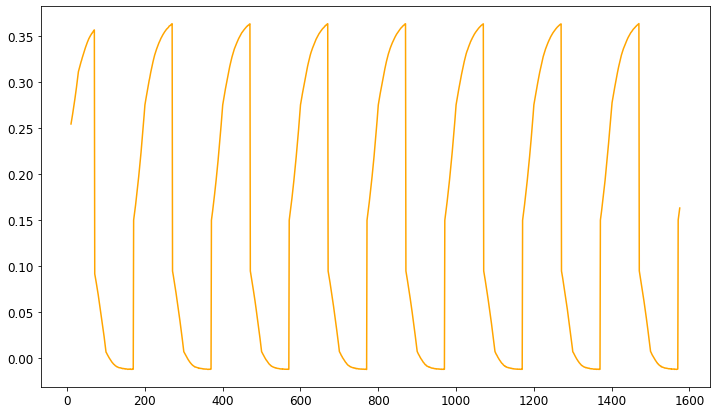

In [0]:
fig = plt.figure(figsize=(12,7))
train_line_real = plt.plot(df_train.index[n_steps:], df_train[use_feature][n_steps:], color="orange", label="Observed (Training)")
train_line_pred = plt.plot(df_train.index[n_steps:], lstm_pred_train[:, 0], color="red", label="LSTM Predict (Training)")
train_line_pred = plt.plot(df_train.index[n_steps:], rnn_pred_train[:, 0], color="blue", label="RNN Predict (Training)")
train_line_pred = plt.plot(df_train.index[n_steps:], gru_pred_train[:, 0], color="black", label="GRU Predict (Training)")
train_line_pred = plt.plot(df_train.index[n_steps:],y_predicted_ar_train, color='green', label="alpha RNN Predict (Training)")
train_line_pred = plt.plot(df_train.index[n_steps:],y_predicted_ar_trian_t, color="yellow", label="alpha_t RNN Predict (Training)" )

plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model (Training)', fontsize=16)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Y', fontsize=20)

fig = plt.figure(figsize=(12,7))
test_line_real = plt.plot(df_test.index[n_steps:], df_test[use_feature][n_steps:], color="orange", label="Observed (Testing)")
test_line_pred = plt.plot(df_test.index[n_steps:], rnn_pred_test[:, 0], color="red", label="RNN Predict (Testing)")
test_line_pred = plt.plot(df_test.index[n_steps:], rnn_pred_test[:, 0], color="blue", label="RNN Predict (Testing)")
test_line_pred = plt.plot(df_test.index[n_steps:], gru_pred_test[:, 0], color="black", label="GRU Predict (Testing)")
test_line_pred = plt.plot(df_test.index[n_steps:], y_predicted_ar,color="green", label="alpha RNN Predict (Testing)")
test_line_pred = plt.plot(df_test,index[n_steps:], y_predicted_ar_t, color="yellow", label= "alpha_t RNN Predict (Testing)")
# train_line_pred = plt.plot(session.run(output, feed_dict={alpharnn.input_layer: x_test_reg})

plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model (Testing)', fontsize=16)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Y', fontsize=20)

plt.show()